# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Group ID: [Your Group ID]**
1.   Student 1: Philip Acquaye-Mensah 2640756
2.   Student 2: Mohamed Jareer MOHAMED  ZEENAM 2596353

---

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression


# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("Group 13 CRWK") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()



---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [4]:
#Identify the student who made a contribution and mention their name in the appropriate section of the code.

## Philip Acquaye-Mensah

# Load the compressed file as a text file
df = spark.read.csv("CourseWork_Dataset_Machine_Learning.csv", header = True)
# Display the DataFrame
df.show(20, truncate= False)

# more info
print(df.count(), df.rdd.getNumPartitions())

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [5]:
# indexer = StringIndexer(inputCol = 'Label', outputCol = 'Label_Index')

# df = indexer.fit(df).transform(df)

# df.show(5, truncate=False)

In [6]:
# df.select("Label_Index").distinct().show(20)

In [7]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Exclude 'Label' column from casting
columns_to_cast = [column for column in df.columns if column != 'Label']

for column in columns_to_cast:
    new_column = column.replace(' ', '_').replace('/', '_per_')
    df = df.withColumnRenamed(column, new_column).withColumn(new_column, col(new_column).cast(FloatType()))

In [8]:
# Check Multi class label
# Label is the column named Label
df.select("Label").distinct().show(20)

+--------------+
|         Label|
+--------------+
|        Benign|
|FTP-BruteForce|
|SSH-Bruteforce|
+--------------+



In [10]:
from pyspark.sql.functions import when, col

# Convert "Label" into a binary classification where "Benign" is 0 and any attack is 1
df = df.withColumn("Label_binary", when(col("Label") == "Benign", 0).otherwise(1))

# Display the updated DataFrame to verify the transformation
df.select("Label", "Label_binary").distinct().show()

+--------------+------------+
|         Label|Label_binary|
+--------------+------------+
|FTP-BruteForce|           1|
|        Benign|           0|
|SSH-Bruteforce|           1|
+--------------+------------+



In [11]:
# Drop Label column because of new binary label and Timestamp column
df = df.drop("Label","Timestamp")

# Print the schema to see the data types and structure
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Byts_per_s: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean:

In [294]:
# df.show(10, truncate=False)

In [12]:
# Check for missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+----------

In [13]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


# Now, use the Imputer on the renamed column
imputer = Imputer(
    inputCols=["Flow_Byts_per_s"],
    outputCols=["Flow_Byts_s_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

# Drop the 'Flow_Byts_per_s' column
df = df.drop('Flow_Byts_per_s')

# Print Schema again to check the changes
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean: float (nullable = true)
 |-- Fwd_IAT_Std: flo

In [297]:
# df.describe("Flow_Byts_s_imputed").show(10)

In [14]:
from pyspark.sql.functions import when

#! Replace Infinity values with nan in "Flow_Byts_s_imputed" column 
df = df.withColumn("Flow_Byts_s_imputed", when(col("Flow_Byts_s_imputed") == float('inf'), float('nan')).otherwise(col("Flow_Byts_s_imputed")))

#! impute nan values with mean
imputer = Imputer(
    inputCols=["Flow_Byts_s_imputed"],
    outputCols=["Flow_Byts_s_nan_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

df = df.drop('Flow_Byts_s_imputed')

df.describe("Flow_Byts_s_nan_imputed").show()

+-------+-----------------------+
|summary|Flow_Byts_s_nan_imputed|
+-------+-----------------------+
|  count|                1048575|
|   mean|     193096.85716243155|
| stddev|      3096074.866298894|
|    min|                    0.0|
|    max|           4.45249984E8|
+-------+-----------------------+



In [15]:
# Check for missing values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+--------

In [16]:
# Summary statistics
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------+-------------+-------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+-----

In [301]:
# df.select("Flow_Byts_s_imputed").distinct().show()

In [302]:
# Now proceed with your VectorAssembler and the rest of the pipeline
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline

# # Assuming 'feature_columns' is updated to exclude 'Flow_Byts_s' and includes 'Flow_Byts_s_imputed'
# feature_columns = [column for column in df.columns if column not in ['Label_binary']]  # Assuming you've already removed 'Flow_Byts_s'

# vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# data = vectorAssembler.transform(df)

# data = data.select('features', 'Label_binary')
# data.show(5)


In [17]:
# Check again for any null or NaN values that might have been introduced
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+--------

In [20]:
vectorAssembler = VectorAssembler(
    inputCols=[
        "Dst_Port", "Protocol", "Flow_Duration", "Tot_Fwd_Pkts", "Tot_Bwd_Pkts",
        "TotLen_Fwd_Pkts", "TotLen_Bwd_Pkts", "Fwd_Pkt_Len_Max", "Fwd_Pkt_Len_Min",
        "Fwd_Pkt_Len_Mean", "Fwd_Pkt_Len_Std", "Bwd_Pkt_Len_Max", "Bwd_Pkt_Len_Min",
        "Bwd_Pkt_Len_Mean", "Bwd_Pkt_Len_Std", "Flow_IAT_Mean", "Flow_IAT_Std",
        "Flow_IAT_Max", "Flow_IAT_Min", "Fwd_IAT_Tot", "Fwd_IAT_Mean", "Fwd_IAT_Std",
        "Fwd_IAT_Max", "Fwd_IAT_Min", "Bwd_IAT_Tot", "Bwd_IAT_Mean", "Bwd_IAT_Std",
        "Bwd_IAT_Max", "Bwd_IAT_Min", "Fwd_PSH_Flags", "Bwd_PSH_Flags", "Fwd_URG_Flags",
        "Bwd_URG_Flags", "Fwd_Header_Len", "Bwd_Header_Len", "Fwd_Pkts_per_s",
        "Bwd_Pkts_per_s", "Pkt_Len_Min", "Pkt_Len_Max", "Pkt_Len_Mean", "Pkt_Len_Std",
        "Pkt_Len_Var", "FIN_Flag_Cnt", "SYN_Flag_Cnt", "RST_Flag_Cnt", "PSH_Flag_Cnt",
        "ACK_Flag_Cnt", "URG_Flag_Cnt", "CWE_Flag_Count", "ECE_Flag_Cnt", "Down_per_Up_Ratio",
        "Pkt_Size_Avg", "Fwd_Seg_Size_Avg", "Bwd_Seg_Size_Avg", "Fwd_Byts_per_b_Avg",
        "Fwd_Pkts_per_b_Avg", "Fwd_Blk_Rate_Avg", "Bwd_Byts_per_b_Avg", "Bwd_Pkts_per_b_Avg",
        "Bwd_Blk_Rate_Avg", "Subflow_Fwd_Pkts", "Subflow_Fwd_Byts", "Subflow_Bwd_Pkts",
        "Subflow_Bwd_Byts", "Init_Fwd_Win_Byts", "Init_Bwd_Win_Byts", "Fwd_Act_Data_Pkts",
        "Fwd_Seg_Size_Min", "Active_Mean", "Active_Std", "Active_Max", "Active_Min",
        "Idle_Mean", "Idle_Std", "Idle_Max", "Idle_Min", 
        "Flow_Byts_s_nan_imputed"
    ],
    outputCol="features"
)


#  TODO
# Move column label index column to the end
# df = df.select(*([c for c in df.columns if c != 'Label_Index'] + ['Label_Index']))

#  select all columns except the last one
# vectorAssembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")


data = vectorAssembler.transform(df)

data = data.select('features', 'Label_binary')
data.show(5)

+--------------------+------------+
|            features|Label_binary|
+--------------------+------------+
|(77,[2,3,15,16,17...|           0|
|(77,[2,3,15,16,17...|           0|
|(77,[2,3,15,16,17...|           0|
|(77,[0,1,2,3,4,5,...|           0|
|(77,[0,1,2,3,4,5,...|           0|
+--------------------+------------+
only showing top 5 rows



In [21]:
# Sparse Vectors
data.show(10, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                                               

In [22]:
# Extract the values from Sparse Vectors to the list format
data_select = data.select('features').limit(2).collect()
for val in data_select:
    dense_vector = val[0].toArray()
    print(dense_vector)

[ 0.00000000e+00  0.00000000e+00  1.12641720e+08  3.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.63208600e+07
  1.39300034e+02  5.63209600e+07  5.63207600e+07  1.12641720e+08
  5.63208600e+07  1.39300034e+02  5.63209600e+07  5.63207600e+07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.66331155e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.00000000e+00  0.00000

### StandardScaler

In [23]:
# Normalizing feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.select("scaledFeatures", "Label_binary")
data.show(3, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                                                                      |Label_binary|
+---------------------------------------------------------------

In [24]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

train_data.printSchema()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Label_binary: integer (nullable = false)



---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [224]:
##1st student name: Philip Acquaye-Mensah
# add the code here


### Apply linear regression model.

In [25]:
lr = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make prediction on the test data
lr_predictions = lr_model.transform(test_data)


In [26]:
lr_predictions.select('prediction', 'Label_binary').distinct().show(10, truncate = False)

+-------------------+------------+
|prediction         |Label_binary|
+-------------------+------------+
|1.0252325853536024 |1           |
|1.025895379539975  |1           |
|1.02591426253155   |1           |
|1.025981011678443  |1           |
|1.025555485226993  |1           |
|1.0252992155245988 |1           |
|1.0260363992606603 |1           |
|0.6252149763378178 |0           |
|0.16207017343979696|0           |
|1.0231337344683284 |1           |
+-------------------+------------+
only showing top 10 rows



In [27]:
# Access the coefficients and intecept of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(coefficients)
print(intercept)

[-0.04625457587783981,-0.0973871497907635,-0.0005534913314640018,-0.01766453094474317,-0.029828481560217102,-0.015892157535484387,-0.10472213903089736,0.053678924142874375,-0.002347140703480492,-0.01635688487758743,-0.026105844939458313,0.07834616293069543,-0.0007679167458575708,-0.04264957335932802,-0.05873412031088593,-0.019456726655171508,-0.04557176769576349,-0.0008853509473370764,0.00030147142427253815,0.0013868148442801335,-0.011913803646730904,-0.04379486430831001,-0.00018873358526616315,0.0008606034446236323,-0.0522838165670767,-0.011429808916080414,0.03050396759504154,-0.015576622074048715,0.016079158707245043,-0.0025471541334166348,0.0,0.0,0.0,0.03718326381088724,0.26623314570693585,0.00995030890771727,-0.016084792245382642,9.050524076449549e-05,-0.0027013904852244072,-0.026098890323946283,0.0626916913954806,-0.005491734288685615,-0.027802883264130603,-0.0025471541334160133,0.001220037111181161,-0.4771777896481735,-0.36884754295651173,0.07879276322786816,0.0,-0.00472071548710

---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [316]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [28]:
##2nd student name:Mohamed Jareer MOHAMED  ZEENAM
# add the code here

# Laaso
lasso = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15) # lambda: tuning
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

# Ridge
ridge = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15) # lambda: tuning
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

In [29]:
lasso_predictions.select('prediction', 'Label_binary').distinct().show(10, truncate = False)

+---------------------+------------+
|prediction           |Label_binary|
+---------------------+------------+
|-0.009240309921235035|0           |
|0.2833347537505557   |0           |
|-0.20429035236909554 |0           |
|0.770959859870207    |1           |
|0.5759098174223465   |0           |
|0.5759098174223465   |1           |
|0.47838479619841623  |0           |
|0.770959859870207    |0           |
|0.380859774974486    |0           |
|0.6734348386462767   |0           |
+---------------------+------------+



---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [319]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [31]:
##2nd student name: Mohamed Jareer MOHAMED ZEENAM
# add the code here

from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'mse')
# calculate Mean Squared Error
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)

evaluator_rmse = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'rmse')
# calculate Root Mean Squared Error
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

evaluator_r2 = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'r2')
# calculate R-squared
r2_score1 = evaluator_r2.evaluate(lr_predictions)
r2_score2 = evaluator_r2.evaluate(lasso_predictions)
r2_score3 = evaluator_r2.evaluate(ridge_predictions)


In [32]:
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score3)

Regression - MSE:  0.004693710787976433 , RMSE:  0.06851066185621353 , R^2:  0.9797175785111802
Lasso - MSE:  0.07761237315667138 , RMSE:  0.27858997318042766 , R^2:  0.6646221004618331
Ridge - MSE:  0.02624546454010488 , RMSE:  0.16200452012244868 , R^2:  0.8865883310629421


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

In [322]:
##1st student name: Philip Acquaye-Mensah
# add the code here


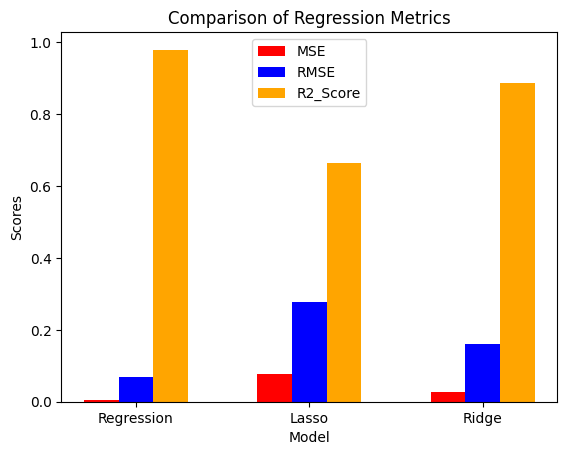

In [35]:
##2nd student name: Mohamed Jareer MOHAMED  ZEENAM
# add the code here

# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score1, r2_score2, r2_score3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE', color = 'red')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE', color = 'blue')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score', color = 'orange')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb